In [1]:
import skimage
import os
from skimage import io
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.color import rgb2hsv
import re
import numpy as np
import seaborn as sns
import scipy.signal as sg
from skimage.transform import rescale, resize, downscale_local_mean
from sklearn.decomposition import SparsePCA
import pywt
from scipy import stats
import timeit
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import pandas as pd
from datetime import datetime
import pytz
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm
from skimage import io
from patchify import patchify, unpatchify
%matplotlib inline
from sklearn.calibration import CalibrationDisplay
import collections

import numpy as np

import scipy.signal as signal
import scipy.special as special
import scipy.optimize as optimize

import matplotlib.pyplot as plt

import skimage.io
import skimage.transform

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression

import dtreeviz 
import pickle

In [2]:
# fog_aware_pivot = pd.read_csv('fog_aware_stats_4_equal_patches_pivot.csv')
# fog_aware_pivot = pd.read_csv('/home/smmrrr/Fog_Imaging_Project/STA_221_project_code/analyses_files/fog_aware_stats_horizontal_3_patches_pivot.csv')
fog_aware_pivot = pd.read_csv('~/Documents/STA_221/fog_aware_stats_horizontal_3_patches_pivot.csv')
fog_aware_pivot['Label_train'] = 1*(fog_aware_pivot['Label']=='foggy')
fog_aware_pivot
fog_aware_pivot.loc[fog_aware_pivot['photo'] == '2022_07-06.1530_pacificcityor.jpg', 'Label'] = 'not_foggy'
###THIS LABEL IS WRONG
fog_aware_pivot.loc[fog_aware_pivot['photo'] == '2022_07-25.1900_pacificcityor.jpg', 'Label'] = 'not_foggy'
fog_aware_pivot.loc[fog_aware_pivot['photo'] == '2022_07-09.0830_lincolncityor.jpg', 'Label'] = 'not_foggy'

fog_aware_pivot.loc[fog_aware_pivot['site'] == 'agatebeachor','site'] = 'Agate Beach'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'lincolncityor','site'] = 'Lincoln City'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'pacificcityor','site'] = 'Pacific City'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'beverlyor','site'] = 'Beverly'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'otterrockor','site'] = 'Otter Rock'
fog_aware_pivot.loc[fog_aware_pivot['site'] == 'cannonbeach','site'] = 'Cannon Beach'


In [20]:
def balance_dataset(X, y):
    # Separate the data into classes
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]

    # Sample an equal number of samples from each class
    num_samples_per_class = min(len(class_0_indices), len(class_1_indices))

    # Randomly sample indices for each class
    sampled_indices_class_0 = np.random.choice(class_0_indices, num_samples_per_class, replace=False)
    sampled_indices_class_1 = np.random.choice(class_1_indices, num_samples_per_class, replace=False)

    # Combine the sampled indices
    sampled_indices = np.concatenate([sampled_indices_class_0, sampled_indices_class_1])

    # Use the sampled indices to create the balanced training set
    X_balanced = X[sampled_indices]
    y_balanced = y[sampled_indices]
    
    # Check the balance in y_train_balanced
    print(np.bincount(y_balanced))

    return(X_balanced, y_balanced, sampled_indices)

In [ ]:
X = np.array(fog_aware_pivot.drop(['photo', 'Label', 'site', 'hour', 'Label_train'], axis = 1)
            )

y = fog_aware_pivot['Label_train']

In [25]:
####create a 50/50 dataset of foggy not foggy
# X_balanced, y_balanced, sample_i = balance_dataset(X, y)


###scale the data
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

    # ####train test split
    # X_train = X_scaled[train_index]
    # X_test = X_scaled[test_index]
    # y_train = y[train_index]
    # y_test = y[test_index]

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(
        X_scaled, y, np.arange(len(X_scaled)), test_size=0.20
    # , random_state=42
    , stratify = y)


In [142]:
# load the model from disk
logistic_model = pickle.load(open('logistic_model.sav', 'rb'))
logistic_model
result = logistic_model.score(X_test, y_test)
print(result)

# Make predictions on the test set
y_test_pred = logistic_model.predict(X_test)


# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, logistic_model.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)


0.93125
Accuracy: 0.93125
Precision: 0.8694158075601375
Recall: 0.7784615384615384
F1 Score: 0.8214285714285714
AUC-ROC Score: 0.9735915535444947


In [31]:
# load the model from disk
random_forest_model = pickle.load(open('random_forest_model.sav', 'rb'))
result = random_forest_model.score(X_test, y_test)
print(result)

# Make predictions on the test set
y_test_pred = random_forest_model.predict(X_test)


# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, random_forest_model.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)


0.968125
Accuracy: 0.968125
Precision: 0.9536423841059603
Recall: 0.8861538461538462
F1 Score: 0.9186602870813396
AUC-ROC Score: 0.9921906485671191


In [111]:
model_name = 'Random Forest'

clf = RandomForestClassifier(n_estimators=5, max_depth=10, max_features='sqrt', random_state=42)

# Train the model on the training set
clf.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)


# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

y_scores = clf.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds_pr = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



####gmm summary stats
# summary_stats = pd.concat([summary_stats,
#                                pd.DataFrame({'model':model_name,
#                 "Accuracy":[accuracy],
#                 "Precision":[precision],
#                 "Recall":[recall],
#                 "F1 Score":[f1],
#                 "AUC":[roc_auc]
#                                             })
#             ], axis = 0)

# #### precision recall 
# precision_recall = pd.concat([precision_recall
# ,pd.DataFrame({'model':model_name,'precision_array':precision_array
#                , 'recall_array':recall_array,'thresholds':np.hstack([0,thresholds_pr]) })
# ],axis=0)
# ###roc chart
# roc = pd.concat([roc
# ,pd.DataFrame({'model':model_name,'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds_roc})
# ],axis=0)
# ##prediction info
# y_info = pd.concat([y_info
# ,pd.DataFrame({'model':model_name,'site':site
#                ,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
# ],axis=0)


Accuracy: 0.928125
Precision: 0.8523489932885906
Recall: 0.7815384615384615
F1 Score: 0.8154093097913322
AUC-ROC Score: 0.9558588235294118


In [116]:
model_name = 'Shallow Decision Tree'

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = clf.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("AUC-ROC Score:", roc_auc)

y_scores = clf.predict_proba(X_test)[:, 1]
# y_scores = gmm.predict(X_test)

# Calculate precision and recall for various thresholds
precision_array, recall_array, thresholds_pr = precision_recall_curve(y_test, y_scores)

fpr, tpr, thresholds_roc = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)



# ####gmm summary stats
# summary_stats = pd.concat([summary_stats,
#                                pd.DataFrame({'model':model_name,
#                 "Accuracy":[accuracy],
#                 "Precision":[precision],
#                 "Recall":[recall],
#                 "F1 Score":[f1],
#                 "AUC":[roc_auc]
#                                             })
#             ], axis = 0)

# #### precision recall 
# precision_recall = pd.concat([precision_recall
# ,pd.DataFrame({'model':model_name,'precision_array':precision_array
#                , 'recall_array':recall_array,'thresholds':np.hstack([0,thresholds_pr]) })
# ],axis=0)
# ###roc chart
# roc = pd.concat([roc
# ,pd.DataFrame({'model':model_name,'fpr':fpr, 'tpr':tpr, 'thresholds':thresholds_roc})
# ],axis=0)
# ##prediction info
# y_info = pd.concat([y_info
# ,pd.DataFrame({'model':model_name,'site':site
#                ,'y_test':y_test,'y_test_pred':y_test_pred, 'y_scores':y_scores})
# ],axis=0)


Accuracy: 0.901875
Precision: 0.7592592592592593
Recall: 0.7569230769230769
F1 Score: 0.7580893682588598
AUC-ROC Score: 0.9111107088989443


In [127]:
all_photos = pd.concat([
pd.read_csv('~/Documents/surfline_all_photos/fog_aware_stats_horizontal_3_patches.csv')
,pd.read_csv('~/Documents/surfline_all_photos/fog_aware_stats_horizontal_3_patches_18000_19000.csv')
,pd.read_csv('~/Documents/surfline_all_photos/fog_aware_stats_horizontal_3_patches_reboot.csv')
,pd.read_csv('~/Documents/surfline_all_photos/fog_aware_stats_horizontal_3_patches_reboot2.csv')

], axis = 0)

all_photos = all_photos.drop(['Unnamed: 0'],axis = 1)
# all_photos



In [124]:
fog_aware_pivot.describe()

,hour,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,sharpness_0,sharpness_1,sharpness_2,...,entropy_2,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,...,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,14.862806,0.175000,0.463616,0.528967,0.068883,0.262772,0.341524,0.010569,0.031945,0.036596,...,3.694940,54.595673,16.466608,8.265383,0.113423,0.113568,0.206798,104.127422,118.473756,137.969236
std,4.372415,0.111553,0.212237,0.202011,0.069255,0.151973,0.174733,0.006907,0.020492,0.021075,...,0.386135,42.196138,27.292968,17.630297,0.096747,0.099156,0.152032,42.103278,41.006924,37.683691
min,0.000000,0.020626,0.021114,0.026509,0.007721,0.007765,0.007934,0.002663,0.002935,0.002815,...,1.657991,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,0.090652,0.285243,0.403082,0.020546,0.120140,0.208189,0.006094,0.013487,0.019528,...,3.462982,13.000000,0.000000,0.000000,0.048033,0.048504,0.098696,75.221621,84.606695,124.409026
50%,15.000000,0.144261,0.510484,0.567017,0.037393,0.283633,0.351700,0.007555,0.030088,0.034792,...,3.752882,52.000000,0.000000,0.000000,0.086372,0.084207,0.160339,90.153093,115.991081,147.882084
75%,19.000000,0.239105,0.632869,0.692844,0.099564,0.384483,0.485876,0.012961,0.045934,0.051278,...,3.975780,93.000000,23.000000,6.000000,0.144089,0.141387,0.261093,140.015270,155.672935,165.622377
max,23.000000,0.784885,0.872326,0.865994,0.604997,0.647252,0.717636,0.066097,0.121406,0.118283,...,4.530500,150.000000,123.000000,112.000000,0.647816,0.697465,0.766886,189.406545,191.282717,190.167628


In [134]:
all_photos_pivot.describe()

,hour_pst,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,sharpness_0,sharpness_1,sharpness_2,...,entropy_2,dark_channel_prior_0,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2
count,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,...,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000,22831.000000
mean,12.993036,0.165836,0.460987,0.539543,0.063881,0.261597,0.353748,0.010341,0.031417,0.037278,...,3.664902,53.915422,16.743726,7.746923,0.115835,0.119152,0.218832,102.429732,119.703416,138.805274
std,3.744044,0.102975,0.205350,0.199618,0.064375,0.147298,0.172421,0.006939,0.019402,0.020593,...,0.400009,42.213356,27.075318,17.475005,0.100681,0.103933,0.159097,42.541579,40.657865,36.215673
min,7.000000,0.016630,0.020422,0.024540,0.006911,0.006299,0.006687,0.001065,0.000917,0.001030,...,1.555545,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.000000,0.088445,0.302350,0.426777,0.020024,0.133156,0.229526,0.006046,0.014733,0.021029,...,3.447878,12.000000,0.000000,0.000000,0.050084,0.052151,0.105907,72.983645,85.106140,124.883672
50%,13.000000,0.134362,0.514271,0.580207,0.034028,0.285546,0.368382,0.007320,0.030328,0.035762,...,3.730262,50.000000,1.000000,0.000000,0.088235,0.087990,0.168168,88.802798,116.926995,147.024332
75%,16.000000,0.229162,0.618435,0.699696,0.091209,0.371671,0.493231,0.012473,0.043959,0.052018,...,3.949656,93.000000,23.000000,4.000000,0.143112,0.145611,0.272111,136.919270,157.692040,166.484042
max,19.000000,0.779563,0.867967,0.880180,0.592262,0.644028,0.728385,0.069633,0.121669,0.119001,...,4.517003,147.000000,124.000000,108.000000,0.708086,0.755902,0.982977,189.996838,191.241281,190.529915


In [128]:
print(all_photos.photo.nunique())

image_files_summary

22831


,photo,Label,year,month,day,hour_central,site,time,time_pst,hour_pst
0,2023_06-10.1000_otterrockor.jpg,not labeled,2023,6,10,10,otterrockor,2023-06-10 10:00:00,2023-06-10 08:00:00-07:00,8
1,2022_08-17.1230_otterrockor.jpg,not labeled,2022,8,17,12,otterrockor,2022-08-17 12:00:00,2022-08-17 10:00:00-07:00,10
2,2023_07-12.2000_lincolncityor.jpg,not labeled,2023,7,12,20,lincolncityor,2023-07-12 20:00:00,2023-07-12 18:00:00-07:00,18
3,2022_08-24.1230_lincolncityor.jpg,not labeled,2022,8,24,12,lincolncityor,2022-08-24 12:00:00,2022-08-24 10:00:00-07:00,10
4,2022_09-24.1500_cannonbeach.jpg,not labeled,2022,9,24,15,cannonbeach,2022-09-24 15:00:00,2022-09-24 13:00:00-07:00,13
...,...,...,...,...,...,...,...,...,...,...
22826,2023_08-17.1100_lincolncityor.jpg,not labeled,2023,8,17,11,lincolncityor,2023-08-17 11:00:00,2023-08-17 09:00:00-07:00,9
22827,2023_05-04.1130_otterrockor.jpg,not labeled,2023,5,4,11,otterrockor,2023-05-04 11:00:00,2023-05-04 09:00:00-07:00,9
22828,2022_08-24.1930_lincolncityor.jpg,not labeled,2022,8,24,19,lincolncityor,2022-08-24 19:00:00,2022-08-24 17:00:00-07:00,17
22829,2022_08-19.1530_lincolncityor.jpg,not labeled,2022,8,19,15,lincolncityor,2022-08-19 15:00:00,2022-08-19 13:00:00-07:00,13


In [129]:
image_files_summary = pd.read_csv('~/Documents/surfline_all_photos/unlabeled_photos_for_model.csv')
all_photos=all_photos.merge(image_files_summary[['photo', 'Label', 'site', 'hour_pst' ]]
                          , on = 'photo')


In [130]:
all_photos.loc[all_photos['photo']=='2023_05-17.1330_otterrockor.jpg']

,photo,patch,mscn_var,vertical_var,sharpness,coef_or_var_sharpness,rms_contrast,entropy,dark_channel_prior,color_sat,CF,Label,site,hour_pst
66000,2023_05-17.1330_otterrockor.jpg,0,0.147567,0.045978,0.008768,0.021497,0.121439,3.246728,35,0.059008,184.469556,not labeled,otterrockor,11
66001,2023_05-17.1330_otterrockor.jpg,1,0.591324,0.323957,0.029075,0.071609,0.107825,2.925324,0,0.178287,60.683809,not labeled,otterrockor,11
66002,2023_05-17.1330_otterrockor.jpg,2,0.702146,0.479898,0.055327,0.157635,0.306363,3.803818,0,0.223313,128.811347,not labeled,otterrockor,11
66003,2023_05-17.1330_otterrockor.jpg,0,0.147567,0.045978,0.008768,0.021497,0.121439,3.246728,35,0.059008,184.469556,not labeled,otterrockor,11
66004,2023_05-17.1330_otterrockor.jpg,1,0.591324,0.323957,0.029075,0.071609,0.107825,2.925324,0,0.178287,60.683809,not labeled,otterrockor,11
66005,2023_05-17.1330_otterrockor.jpg,2,0.702146,0.479898,0.055327,0.157635,0.306363,3.803818,0,0.223313,128.811347,not labeled,otterrockor,11


In [131]:
all_photos.drop([66000, 66001, 66002], inplace=True)

In [132]:
tt = all_photos[['photo', 'Label', 'site', 'hour_pst', 'patch']].value_counts().reset_index()
tt.loc[tt[0]>1]

,photo,Label,site,hour_pst,patch,0


In [133]:
all_photos['patch'] = all_photos['patch'].astype(str)
all_photos_pivot = all_photos.pivot(
index = ['photo', 'Label', 'site', 'hour_pst']
    ,columns = ['patch']
    , values = [ 'mscn_var', 'vertical_var', 'sharpness',
       'coef_or_var_sharpness', 'rms_contrast', 'entropy', 'dark_channel_prior',
       'color_sat', 'CF']
)
all_photos_pivot.columns = all_photos_pivot.columns.map('_'.join)
all_photos_pivot=all_photos_pivot.reset_index()
print(all_photos_pivot.columns)

# fog_aware3_pivot.dropna().to_csv('fog_aware_stats_horizontal_3_patches_pivot.csv', index=False)



Index(['photo', 'Label', 'site', 'hour_pst', 'mscn_var_0', 'mscn_var_1',
       'mscn_var_2', 'vertical_var_0', 'vertical_var_1', 'vertical_var_2',
       'sharpness_0', 'sharpness_1', 'sharpness_2', 'coef_or_var_sharpness_0',
       'coef_or_var_sharpness_1', 'coef_or_var_sharpness_2', 'rms_contrast_0',
       'rms_contrast_1', 'rms_contrast_2', 'entropy_0', 'entropy_1',
       'entropy_2', 'dark_channel_prior_0', 'dark_channel_prior_1',
       'dark_channel_prior_2', 'color_sat_0', 'color_sat_1', 'color_sat_2',
       'CF_0', 'CF_1', 'CF_2'],
      dtype='object')


In [136]:

all_photos_pivot = pd.concat([all_photos_pivot,fog_aware_pivot ], axis = 0)
# fog_aware_pivot['Label_train'] = 1*(fog_aware_pivot['Label']=='foggy')


In [137]:
# all_photos_pivot = all_photos_pivot.reset_index()
all_photos_pivot.loc[all_photos_pivot['Label']=='foggy', 'Label_train'] = 1
all_photos_pivot.loc[all_photos_pivot['Label']=='not_foggy', 'Label_train'] = 0
# all_photos_pivot['Label_train'] = 1*(all_photos_pivot['Label']=='foggy')
all_photos_pivot['Label_train'].unique()

array([nan,  0.,  1.])

In [146]:
all_photos_pivot

,photo,Label,site,hour_pst,mscn_var_0,mscn_var_1,mscn_var_2,vertical_var_0,vertical_var_1,vertical_var_2,...,dark_channel_prior_1,dark_channel_prior_2,color_sat_0,color_sat_1,color_sat_2,CF_0,CF_1,CF_2,hour,Label_train
0,2022_07-04.0900_otterrockor.jpg,not labeled,otterrockor,7.0,0.279698,0.543419,0.656706,0.095084,0.316788,0.458292,...,0.0,0.0,0.062379,0.039828,0.140357,98.332333,124.026715,171.231544,NaN,NaN
1,2022_07-04.0930_beverlyor.jpg,not labeled,beverlyor,7.0,0.238107,0.561673,0.719150,0.070764,0.290802,0.473943,...,30.0,0.0,0.020508,0.061788,0.165616,148.251313,90.245005,147.594513,NaN,NaN
2,2022_07-04.0930_otterrockor.jpg,not labeled,otterrockor,7.0,0.403777,0.719505,0.571357,0.166115,0.434216,0.395062,...,0.0,0.0,0.066679,0.051188,0.221231,79.163271,116.189373,165.956309,NaN,NaN
3,2022_07-04.0930_pacificcityor.jpg,not labeled,pacificcityor,7.0,0.231322,0.513705,0.777215,0.059372,0.241226,0.604567,...,0.0,0.0,0.046810,0.151136,0.536047,116.502583,84.795577,153.249968,NaN,NaN
4,2022_07-04.1000_agatebeachor.jpg,not labeled,agatebeachor,8.0,0.160435,0.357634,0.313640,0.036552,0.186416,0.136367,...,5.0,26.0,0.061176,0.104517,0.263867,63.201256,148.925232,132.295325,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7991,2023_09-30.1900_agatebeachor.jpg,not_foggy,agatebeachor,NaN,0.176457,0.743293,0.523022,0.083535,0.457137,0.265502,...,0.0,0.0,0.041942,0.085205,0.077075,182.964334,69.402653,135.332656,19.0,0.0
7992,2023_09-30.1930_cannonbeach.jpg,not_foggy,cannonbeach,NaN,0.164592,0.585149,0.640644,0.042335,0.314184,0.390172,...,0.0,0.0,0.039959,0.058892,0.092489,137.364165,106.650678,174.568957,19.0,0.0
7993,2023_09-30.2000_otterrockor.jpg,not_foggy,otterrockor,NaN,0.282921,0.442290,0.345411,0.136875,0.235093,0.183542,...,3.0,0.0,0.125098,0.145597,0.143351,176.593142,127.302494,142.248589,20.0,0.0
7994,2023_09-30.2030_otterrockor.jpg,not_foggy,otterrockor,NaN,0.193967,0.582705,0.378667,0.059283,0.307785,0.207709,...,0.0,0.0,0.137039,0.243238,0.247271,175.215470,145.617058,152.212567,20.0,0.0


In [147]:
X = np.array(all_photos_pivot.drop(['photo', 'Label', 'site', 'hour', 'hour_pst', 'Label_train'], axis = 1)
            )
X_scaled = preprocessing.StandardScaler().fit_transform(X)
# X_scaled = scaler.transform(X_balanced)
print(X_scaled.shape)

(30827, 27)


In [165]:
y_pred_logit = logistic_model.predict(X_scaled)
y_pred_rf = random_forest_model.predict(X_scaled)


In [119]:
clf

DecisionTreeClassifier(max_depth=3)

In [166]:
print(np.bincount(y_pred_logit))
print(np.bincount(y_pred_rf))

[25464  5363]
[25273  5554]


In [150]:
5363/(5363+25464)

0.17397086969215297

In [114]:
1553/29274

0.05305048848807816

In [88]:
7668/23159

0.33110237920462887

In [167]:
results = pd.concat([
    all_photos_pivot[['photo', 'Label', 'site','Label_train' ]].reset_index(drop=True)
    , pd.DataFrame({'rf_pred':y_pred_rf})
    , pd.DataFrame({'logit_pred':y_pred_logit})
], axis = 1)
results

,photo,Label,site,Label_train,rf_pred,logit_pred
0,2022_07-04.0900_otterrockor.jpg,not labeled,otterrockor,NaN,0,0
1,2022_07-04.0930_beverlyor.jpg,not labeled,beverlyor,NaN,0,0
2,2022_07-04.0930_otterrockor.jpg,not labeled,otterrockor,NaN,0,0
3,2022_07-04.0930_pacificcityor.jpg,not labeled,pacificcityor,NaN,0,0
4,2022_07-04.1000_agatebeachor.jpg,not labeled,agatebeachor,NaN,0,0
...,...,...,...,...,...,...
30822,2023_09-30.1900_agatebeachor.jpg,not_foggy,agatebeachor,0.0,0,0
30823,2023_09-30.1930_cannonbeach.jpg,not_foggy,cannonbeach,0.0,0,0
30824,2023_09-30.2000_otterrockor.jpg,not_foggy,otterrockor,0.0,0,0
30825,2023_09-30.2030_otterrockor.jpg,not_foggy,otterrockor,0.0,0,0


In [103]:
y_pred

array([0, 1, 0, ..., 1, 0, 0])

In [169]:
results_check = results.dropna()
results_check = results_check.reset_index()

In [170]:
results_check['accuracy_rf'] = 1*(results_check['Label_train'] == results_check['rf_pred'])
results_check['accuracy_logit'] = 1*(results_check['Label_train'] == results_check['logit_pred'])

print('random forest')

print(results_check['accuracy_rf'].mean())
print(results_check.loc[results_check['Label_train']==1,['accuracy_rf']].mean())
print(results_check.loc[results_check['rf_pred']==1,['accuracy_rf']].mean())

print('logistic')

print(results_check['accuracy_logit'].mean())
print(results_check.loc[results_check['Label_train']==1,['accuracy_logit']].mean())
print(results_check.loc[results_check['logit_pred']==1,['accuracy_logit']].mean())


# plot_site_accuracy = y_info.groupby(['model', 'site']
#                                    )['accuracy'].mean().reset_index()
# # plot_site_accuracy
# plot_site_precision = y_info.loc[y_info['y_test'] == 1].groupby(['model', 'site']
#                                    )['accuracy'].mean().reset_index()

# plot_site_recall = y_info.loc[y_info['y_test_pred'] == 1].groupby(['model', 'site']
#                                    )['accuracy'].mean().reset_index()

random forest
0.950975487743872
accuracy_rf    0.82984
dtype: float64
accuracy_rf    0.920657
dtype: float64
logistic
0.9305902951475737
accuracy_logit    0.760173
dtype: float64
accuracy_logit    0.881344
dtype: float64


In [174]:
results.loc[results['site'] == 'agatebeachor','site'] = 'Agate Beach'
results.loc[results['site'] == 'lincolncityor','site'] = 'Lincoln City'
results.loc[results['site'] == 'pacificcityor','site'] = 'Pacific City'
results.loc[results['site'] == 'beverlyor','site'] = 'Beverly'
results.loc[results['site'] == 'otterrockor','site'] = 'Otter Rock'
results.loc[results['site'] == 'cannonbeach','site'] = 'Cannon Beach'

results

,photo,Label,site,Label_train,rf_pred,logit_pred,random_forest_label,logistic_regression_label
0,2022_07-04.0900_otterrockor.jpg,not labeled,Otter Rock,NaN,0,0,Not Foggy,Not Foggy
1,2022_07-04.0930_beverlyor.jpg,not labeled,Beverly,NaN,0,0,Not Foggy,Not Foggy
2,2022_07-04.0930_otterrockor.jpg,not labeled,Otter Rock,NaN,0,0,Not Foggy,Not Foggy
3,2022_07-04.0930_pacificcityor.jpg,not labeled,Pacific City,NaN,0,0,Not Foggy,Not Foggy
4,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
...,...,...,...,...,...,...,...,...
30822,2023_09-30.1900_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy
30823,2023_09-30.1930_cannonbeach.jpg,not_foggy,Cannon Beach,0.0,0,0,Not Foggy,Not Foggy
30824,2023_09-30.2000_otterrockor.jpg,not_foggy,Otter Rock,0.0,0,0,Not Foggy,Not Foggy
30825,2023_09-30.2030_otterrockor.jpg,not_foggy,Otter Rock,0.0,0,0,Not Foggy,Not Foggy


In [179]:
print(np.bincount(y_pred_logit))
print(np.bincount(y_pred_rf))

[25464  5363]
[25273  5554]


In [182]:
np.bincount(y_pred_logit)/np.bincount(y_pred_logit).sum()


array([0.82602913, 0.17397087])

In [181]:
np.bincount(y_pred_rf)/np.bincount(y_pred_rf).sum()

array([0.81983326, 0.18016674])

In [183]:
results.loc[results['rf_pred'] == 1,'random_forest_label'] = 'Foggy (18%)'
results.loc[results['rf_pred'] == 0,'random_forest_label'] = 'Not Foggy (82%)'

results.loc[results['logit_pred'] == 1,'logistic_regression_label'] = 'Foggy (17%)'
results.loc[results['logit_pred'] == 0,'logistic_regression_label'] = 'Not Foggy (83%)'

In [184]:
barplot = results.groupby(['site','random_forest_label'])[['site','random_forest_label']].value_counts().reset_index()

plot_data = barplot.pivot(index='site', columns = 'random_forest_label', values = 0)

plot_data

random_forest_label,Foggy (18%),Not Foggy (82%)
site,,
Agate Beach,1329,4860
Beverly,400,1119
Cannon Beach,656,5130
Lincoln City,1744,4056
Otter Rock,701,4684
Pacific City,724,5424


<Figure size 1000x600 with 0 Axes>

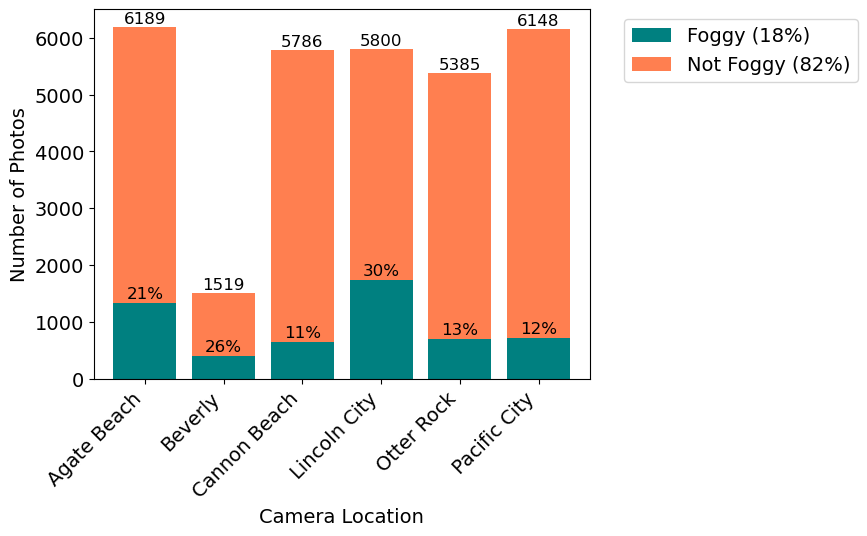

In [185]:
### stats for the site wise counts

plt.figure(figsize=(10, 6))
# Create a barplot with counts on top
# ax = sns.barplot(x='site', y=0
#                ,  palette=custom_palette
#                  , data=barplot, hue = 'Label', dodge = True)

ax = plot_data.plot(kind='bar', stacked=True, color = ['teal', 'coral'], width = 0.8)
# Add counts on top of the bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
lgnd = plt.legend(
    # title='Custom Label', 
                  bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14 
                                                                   })
# Add values on top of each bar
# for p in ax.patches:
#     value = round(p.get_height())
#     ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add sum of values on top of each stacked group
for idx, value in enumerate(plot_data.sum(axis=1)):
    ax.text(idx, value + 10, f'{value}', ha='center', va='bottom', fontsize=12)

# first_stack_sum = plot_data.iloc[:, 0].sum()
for idx, value in enumerate(plot_data.iloc[:, 0]):
    percentage = (value / plot_data.iloc[idx, 0:2].sum()) * 100
    ax.text(idx, value + 30, f'{percentage:.0f}%', ha='center', va='bottom', fontsize=12)

plt.xlabel('Camera Location', fontsize = 14)
# plt.ylim(0, 2500)
plt.ylabel('Number of Photos', fontsize = 14)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=14)

# Show the plot
plt.show()


In [186]:
barplot = results.groupby(['site','logistic_regression_label'])[['site','logistic_regression_label']].value_counts().reset_index()

plot_data = barplot.pivot(index='site', columns = 'logistic_regression_label', values = 0)

plot_data

logistic_regression_label,Foggy (17%),Not Foggy (83%)
site,,
Agate Beach,1316,4873
Beverly,418,1101
Cannon Beach,601,5185
Lincoln City,1748,4052
Otter Rock,663,4722
Pacific City,617,5531


<Figure size 1000x600 with 0 Axes>

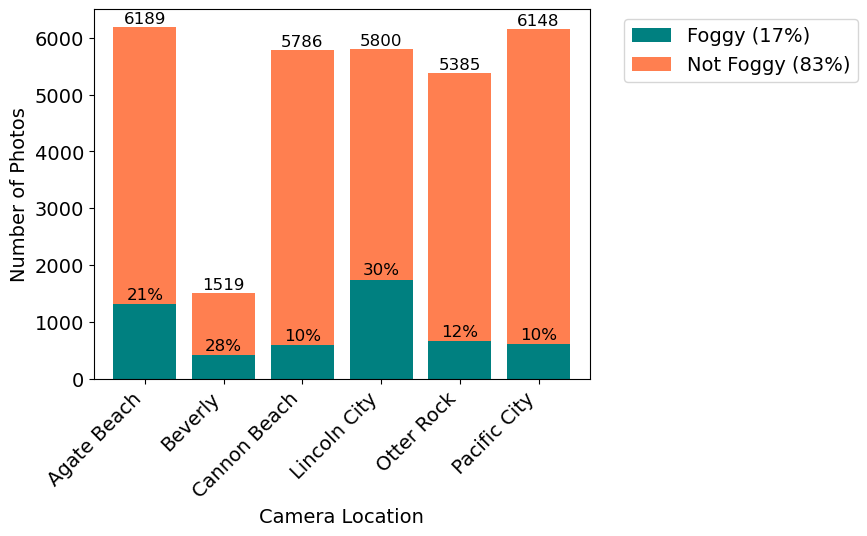

In [187]:
### stats for the site wise counts

plt.figure(figsize=(10, 6))
# Create a barplot with counts on top
# ax = sns.barplot(x='site', y=0
#                ,  palette=custom_palette
#                  , data=barplot, hue = 'Label', dodge = True)

ax = plot_data.plot(kind='bar', stacked=True, color = ['teal', 'coral'], width = 0.8)
# Add counts on top of the bars
# for p in ax.patches:
#     ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
lgnd = plt.legend(
    # title='Custom Label', 
                  bbox_to_anchor=(1.05, 1), loc='upper left', prop={'size': 14 
                                                                   })
# Add values on top of each bar
# for p in ax.patches:
#     value = round(p.get_height())
#     ax.annotate(f'{value}', (p.get_x() + p.get_width() / 2., p.get_height()),
#                 ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Add sum of values on top of each stacked group
for idx, value in enumerate(plot_data.sum(axis=1)):
    ax.text(idx, value + 10, f'{value}', ha='center', va='bottom', fontsize=12)

# first_stack_sum = plot_data.iloc[:, 0].sum()
for idx, value in enumerate(plot_data.iloc[:, 0]):
    percentage = (value / plot_data.iloc[idx, 0:2].sum()) * 100
    ax.text(idx, value + 30, f'{percentage:.0f}%', ha='center', va='bottom', fontsize=12)

plt.xlabel('Camera Location', fontsize = 14)
# plt.ylim(0, 2500)
plt.ylabel('Number of Photos', fontsize = 14)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=14)

# Show the plot
plt.show()


In [190]:
asos = pd.read_csv('~/Documents/surfline_all_photos/oregon_asos.csv')
asos['valid'] = pd.to_datetime(asos['valid'])
asos['day'] = asos.valid.dt.date

/var/folders/6d/4h428hj560j7r870zw5g39180000gn/T/ipykernel_1829/1914541578.py:1: DtypeWarning: Columns (10,18) have mixed types. Specify dtype option on import or set low_memory=False.
  asos = pd.read_csv('~/Documents/surfline_all_photos/oregon_asos.csv')


In [226]:
all_desc = pd.read_csv('~/Documents/surfline_all_photos/desc_photos_for_model.csv')
all_desc['time_pst'] = pd.to_datetime(all_desc['time_pst'])
all_desc['year'] = all_desc['time_pst'].dt.year
all_desc['month'] = all_desc['time_pst'].dt.month
all_desc['day'] = all_desc['time_pst'].dt.day
all_desc['hour_pst'] = all_desc['time_pst'].dt.hour



In [194]:
onp = asos.loc[(asos['station'] == 'ONP') & (asos['valid'] >= '2022-01-01')]

In [196]:
onp = onp[['valid','vsby', 'relh' ]]

In [224]:
original_timezone = pytz.timezone('UTC')

# # Convert to Pacific Time
pacific_timezone = pytz.timezone('US/Pacific')
onp['time_pst'] = onp['valid'].dt.tz_localize(original_timezone).dt.tz_convert(pacific_timezone)


onp['year'] = onp['time_pst'].dt.year
onp['month'] = onp['time_pst'].dt.month
onp['day'] = onp['time_pst'].dt.day
onp['hour_pst'] = onp['time_pst'].dt.hour
onp['fog_binary'] = (onp['vsby'] < 0.62)*1



In [230]:
tt = all_desc.groupby(['photo', 'year', 'month', 'day', 'hour_pst']).value_counts().reset_index()
tt.loc[tt[0]>1]

,photo,year,month,day,hour_pst,Label,hour_central,site,time,time_pst,0


In [235]:
onp['min_time_filter'] = onp.groupby(['year', 'month', 'day', 'hour_pst'])['time_pst'].transform('min')
onp_merge = onp.loc[onp['time_pst'] == onp['min_time_filter']]
onp_merge

,valid,vsby,relh,year,month,day,hour,hour_pst,fog_binary,time_pst,min_time_filter
1015609,2022-01-01 00:15:00,10.0,65.38,2021,12,31,0,16,0,2021-12-31 16:15:00-08:00,2021-12-31 16:15:00-08:00
1015616,2022-01-01 01:15:00,10.0,74.98,2021,12,31,1,17,0,2021-12-31 17:15:00-08:00,2021-12-31 17:15:00-08:00
1015622,2022-01-01 02:15:00,10.0,93.03,2021,12,31,2,18,0,2021-12-31 18:15:00-08:00,2021-12-31 18:15:00-08:00
1015628,2022-01-01 03:15:00,10.0,93.03,2021,12,31,3,19,0,2021-12-31 19:15:00-08:00,2021-12-31 19:15:00-08:00
1015634,2022-01-01 04:15:00,10.0,93.03,2021,12,31,4,20,0,2021-12-31 20:15:00-08:00,2021-12-31 20:15:00-08:00
...,...,...,...,...,...,...,...,...,...,...,...
1072598,2023-02-25 15:55:00,10.0,63.75,2023,2,25,15,7,0,2023-02-25 07:55:00-08:00,2023-02-25 07:55:00-08:00
1072607,2023-02-25 18:35:00,10.0,48.10,2023,2,25,18,10,0,2023-02-25 10:35:00-08:00,2023-02-25 10:35:00-08:00
1072612,2023-02-25 19:55:00,10.0,45.14,2023,2,25,19,11,0,2023-02-25 11:55:00-08:00,2023-02-25 11:55:00-08:00
1072617,2023-02-25 21:15:00,10.0,52.45,2023,2,25,21,13,0,2023-02-25 13:15:00-08:00,2023-02-25 13:15:00-08:00


In [249]:
results.loc[results['rf_pred'] == 1,'random_forest_label'] = 'Foggy'
results.loc[results['rf_pred'] == 0,'random_forest_label'] = 'Not Foggy'

results.loc[results['logit_pred'] == 1,'logistic_regression_label'] = 'Foggy'
results.loc[results['logit_pred'] == 0,'logistic_regression_label'] = 'Not Foggy'
agate = results.loc[results['site']=='Agate Beach']
agate

,photo,Label,site,Label_train,rf_pred,logit_pred,random_forest_label,logistic_regression_label
4,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
7,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
12,2022_07-04.1200_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
15,2022_07-04.1230_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
21,2022_07-04.1330_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy
...,...,...,...,...,...,...,...,...
30806,2023_09-30.1200_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy
30817,2023_09-30.1600_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy
30818,2023_09-30.1630_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy
30821,2023_09-30.1800_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy


In [250]:
compare = agate.merge(all_desc[['photo','year', 'month', 'day', 'hour_pst']], on = 'photo')
compare = compare.merge(onp_merge, on = ['year', 'month', 'day', 'hour_pst'])

In [257]:
compare['accuarcy_rf'] = (compare['rf_pred'] == compare['fog_binary'])*1
compare['accuarcy_logit'] = (compare['logit_pred'] == compare['fog_binary'])*1
compare['accuarcy_labels'] = (compare['Label_train'] == compare['fog_binary'])*1
compare.loc[compare['Label_train'].isna(), 'accuarcy_labels'] = np.nan

In [259]:
print(compare['accuarcy_rf'].mean())
print(compare['accuarcy_logit'].mean())
print(compare['accuarcy_labels'].mean())



0.6625766871165644
0.6290703161868806
0.7597402597402597


In [266]:
compare

,photo,Label,site,Label_train,rf_pred,logit_pred,random_forest_label,logistic_regression_label,year,month,...,valid,vsby,relh,hour,fog_binary,time_pst,min_time_filter,accuarcy_rf,accuarcy_labels,accuarcy_logit
0,2022_07-04.1000_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy,2022,7,...,2022-07-04 15:15:00,10.0,76.98,15,0,2022-07-04 08:15:00-07:00,2022-07-04 08:15:00-07:00,1,NaN,1
1,2022_07-04.1030_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,7,...,2022-07-04 15:15:00,10.0,76.98,15,0,2022-07-04 08:15:00-07:00,2022-07-04 08:15:00-07:00,1,1.0,1
2,2022_07-04.1100_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy,2022,7,...,2022-07-04 16:15:00,10.0,77.14,16,0,2022-07-04 09:15:00-07:00,2022-07-04 09:15:00-07:00,1,NaN,1
3,2022_07-04.1130_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,7,...,2022-07-04 16:15:00,10.0,77.14,16,0,2022-07-04 09:15:00-07:00,2022-07-04 09:15:00-07:00,1,1.0,1
4,2022_07-04.1200_agatebeachor.jpg,not labeled,Agate Beach,NaN,0,0,Not Foggy,Not Foggy,2022,7,...,2022-07-04 17:15:00,NaN,82.12,17,0,2022-07-04 10:15:00-07:00,2022-07-04 10:15:00-07:00,1,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2114,2022_09-24.1230_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,9,...,2022-09-24 17:15:00,10.0,73.55,17,0,2022-09-24 10:15:00-07:00,2022-09-24 10:15:00-07:00,1,1.0,1
2115,2022_09-24.1600_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,9,...,2022-09-24 21:15:00,10.0,81.56,21,0,2022-09-24 14:15:00-07:00,2022-09-24 14:15:00-07:00,1,1.0,1
2116,2022_09-24.1630_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,9,...,2022-09-24 21:15:00,10.0,81.56,21,0,2022-09-24 14:15:00-07:00,2022-09-24 14:15:00-07:00,1,1.0,1
2117,2022_09-30.1200_agatebeachor.jpg,not_foggy,Agate Beach,0.0,0,0,Not Foggy,Not Foggy,2022,9,...,2022-09-30 17:10:00,10.0,100.00,17,0,2022-09-30 10:10:00-07:00,2022-09-30 10:10:00-07:00,1,1.0,1


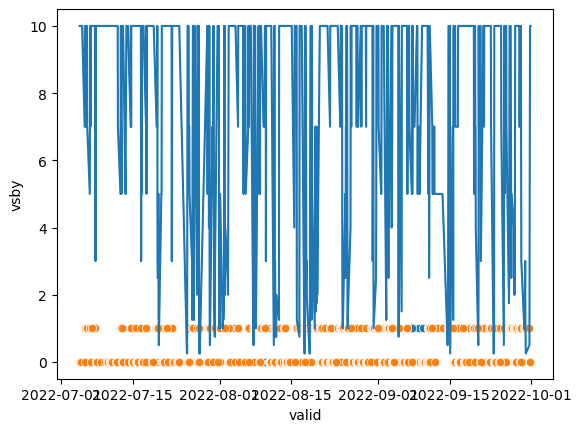

In [265]:
plt_data = compare.loc[compare['valid'].between('2022-06-01', '2022-10-01')].reset_index()

ax = sns.lineplot(x = 'valid', y = 'vsby', data = plt_data)
tt = sns.scatterplot(x = 'valid', y = 'rf_pred', data = plt_data)
tt2 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data)

In [288]:
plt_data = compare.loc[compare['valid'].between('2022-07-01', '2022-09-01')].reset_index()
plt_data['relh'] = plt_data['relh']/100
plt_data.loc[plt_data['rf_pred'] == 0, 'rf_pred'] = np.nan
plt_data.loc[plt_data['rf_pred'] == 1, 'rf_pred'] = 1.025
plt_data.loc[plt_data['logit_pred'] == 0, 'logit_pred'] = np.nan
plt_data.loc[plt_data['logit_pred'] == 1, 'logit_pred'] = 1.05
plt_data.loc[plt_data['Label_train'] == 0, 'Label_train'] = np.nan


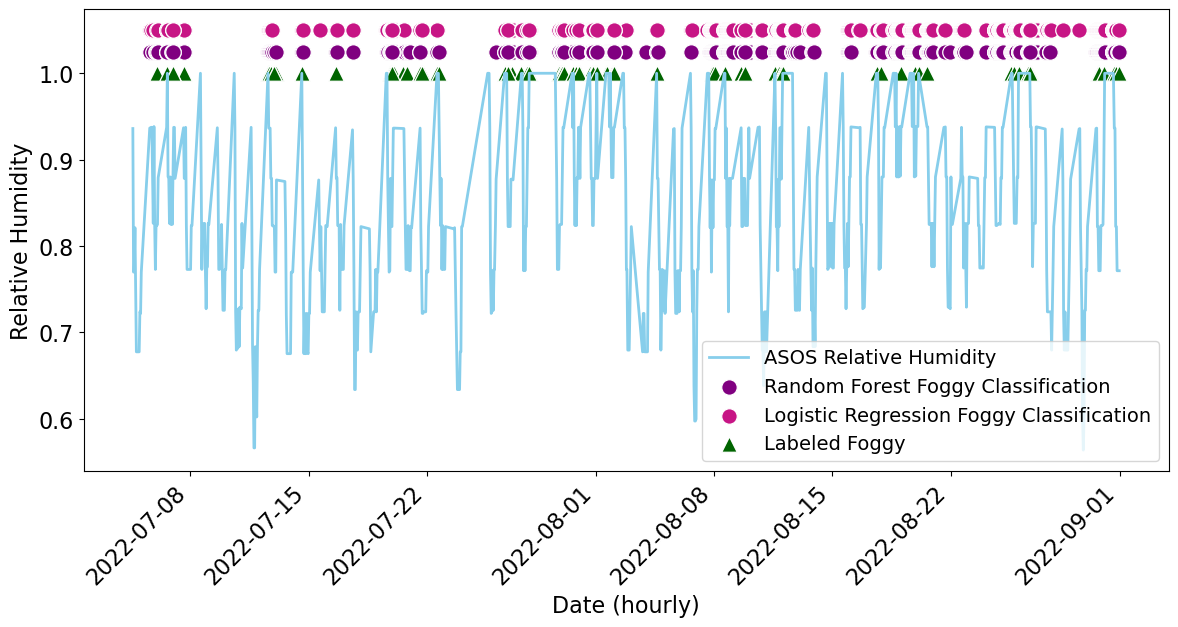

In [283]:
plt.figure(figsize=(14, 6)) 
ax = sns.lineplot(x = 'valid', y = 'relh', data = plt_data
                 , label='ASOS Relative Humidity', color='skyblue', lw = 2)
tt = sns.scatterplot(x = 'valid', y = 'rf_pred', data = plt_data
                   , label='Random Forest Foggy Classification', color='purple', s = 125 )
t1 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data
                   , label='Logistic Regression Foggy Classification', color='mediumvioletred', s = 125 )
t2 = sns.scatterplot(x = 'valid', y = 'Label_train', data = plt_data
                   , label='Labeled Foggy', color='darkgreen' , marker='^', s = 125)
# tt2 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data)
plt.xlabel('Date (hourly)', fontsize = 16)
# plt.ylim(0, 2500)
plt.ylabel('Relative Humidity', fontsize = 16)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment
plt.legend(fontsize=14)

In [298]:
plt_data = compare.loc[compare['valid'].between('2022-07-01', '2022-09-01')].reset_index()
plt_data['vsby'] = plt_data['vsby']/1.60934
plt_data.loc[plt_data['rf_pred'] == 0, 'rf_pred'] = np.nan
plt_data.loc[plt_data['rf_pred'] == 1, 'rf_pred'] = .5
plt_data.loc[plt_data['logit_pred'] == 0, 'logit_pred'] = np.nan
plt_data.loc[plt_data['logit_pred'] == 1, 'logit_pred'] = .25
plt_data.loc[plt_data['Label_train'] == 0, 'Label_train'] = np.nan
plt_data.loc[plt_data['Label_train'] == 1, 'Label_train'] = 0


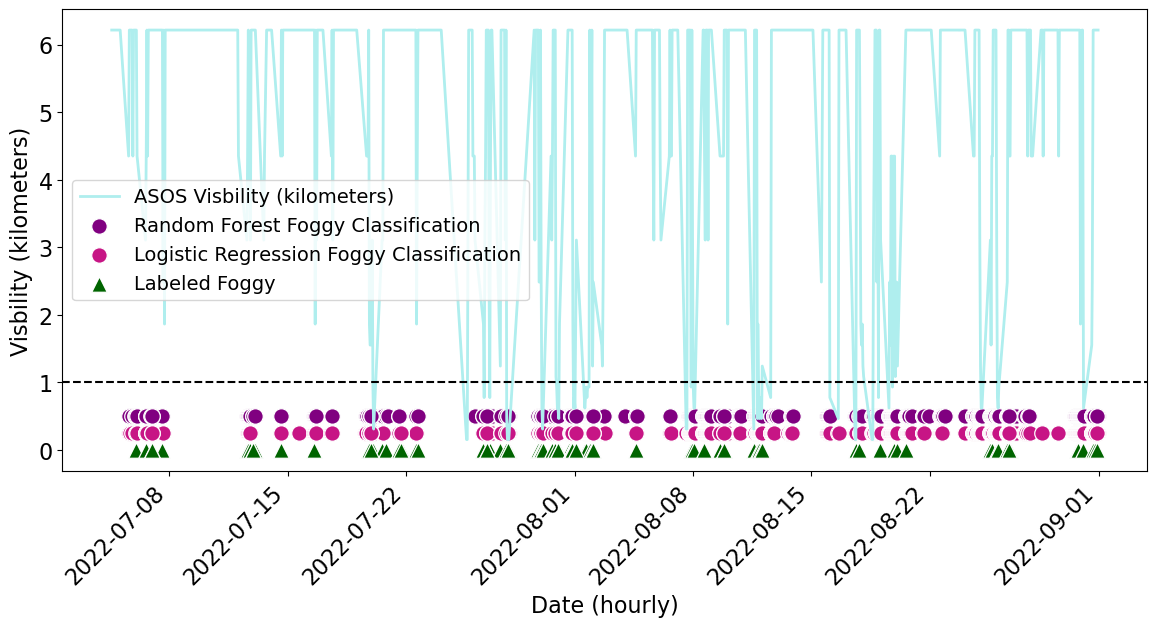

In [300]:
plt.figure(figsize=(14, 6)) 
ax = sns.lineplot(x = 'valid', y = 'vsby', data = plt_data
                 , label='ASOS Visbility (kilometers)', color='paleturquoise', lw = 2)
tt = sns.scatterplot(x = 'valid', y = 'rf_pred', data = plt_data
                   , label='Random Forest Foggy Classification', color='purple', s = 125 )
t1 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data
                   , label='Logistic Regression Foggy Classification', color='mediumvioletred', s = 125 )
t2 = sns.scatterplot(x = 'valid', y = 'Label_train', data = plt_data
                   , label='Labeled Foggy', color='darkgreen' , marker='^', s = 125)
# tt2 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data)
plt.axhline(y=1, color='black', linestyle='--')
plt.xlabel('Date (hourly)', fontsize = 16)
# plt.ylim(0, 2500)
plt.ylabel('Visbility (kilometers)', fontsize = 16)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment
plt.legend(fontsize=14)

In [284]:
plt_data = compare.loc[compare['valid'].between('2023-07-01', '2023-09-01')].reset_index()
plt_data['relh'] = plt_data['relh']/100
plt_data.loc[plt_data['rf_pred'] == 0, 'rf_pred'] = np.nan
plt_data.loc[plt_data['rf_pred'] == 1, 'rf_pred'] = 1.025
plt_data.loc[plt_data['logit_pred'] == 0, 'logit_pred'] = np.nan
plt_data.loc[plt_data['logit_pred'] == 1, 'logit_pred'] = 1.05
plt_data.loc[plt_data['Label_train'] == 0, 'Label_train'] = np.nan


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


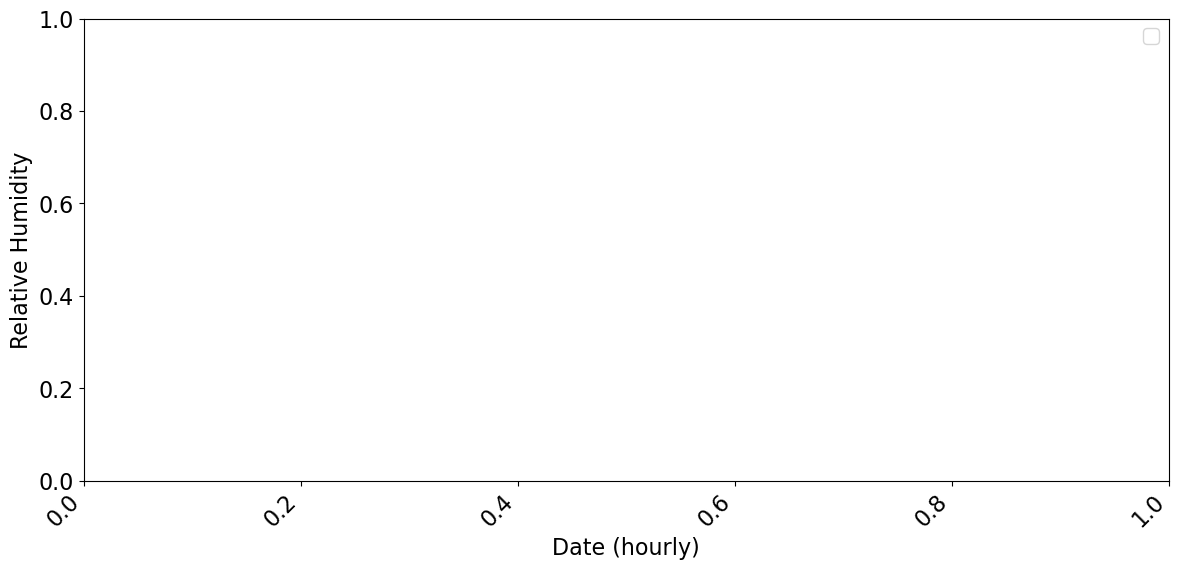

In [285]:
plt.figure(figsize=(14, 6)) 
ax = sns.lineplot(x = 'valid', y = 'relh', data = plt_data
                 , label='ASOS Relative Humidity', color='skyblue', lw = 2)
tt = sns.scatterplot(x = 'valid', y = 'rf_pred', data = plt_data
                   , label='Random Forest Foggy Classification', color='purple', s = 125 )
t1 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data
                   , label='Logistic Regression Foggy Classification', color='mediumvioletred', s = 125 )
t2 = sns.scatterplot(x = 'valid', y = 'Label_train', data = plt_data
                   , label='Labeled Foggy', color='darkgreen' , marker='^', s = 125)
# tt2 = sns.scatterplot(x = 'valid', y = 'logit_pred', data = plt_data)
plt.xlabel('Date (hourly)', fontsize = 16)
# plt.ylim(0, 2500)
plt.ylabel('Relative Humidity', fontsize = 16)
# plt.tight_layout()  # Ensure labels are not cut off
plt.tick_params(axis='both', labelsize=16)
plt.xticks(rotation=45, ha='right')  # 'ha' stands for horizontal alignment
plt.legend(fontsize=14)